# Evaluate Model
This notebooks loads a specific model so that you can evaluate it.

In [1]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading model
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_sngp/seed3/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model(torch.randn(1, 3, 32, 32))
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(checkpoint['args'])
ood_datasets = build_ood_datasets(checkpoint['args'], ds_info['mean'], ds_info['std'])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, sampler=None)# range(1000))
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=256, sampler=None)# range(1000))

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [3]:
# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits.append(model(inp.to(device), mean_field=True).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_ood.append(model(inp.to(device), mean_field=True).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


In [4]:
# Compute results
entropy_id = ood.entropy_fn(logits.softmax(-1))
entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.CrossEntropyLoss()

results = {
    'ACC': generalization.accuracy(logits, targets)[0].item(),
    'TCE': tce_criterion(logits.softmax(-1), targets).item(),
    'NLL': nll_criterion(logits, targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(results)

{'ACC': 96.29000091552734, 'TCE': 0.017654847353696823, 'NLL': 0.13676445186138153, 'AUROC': 0.958946696373694}


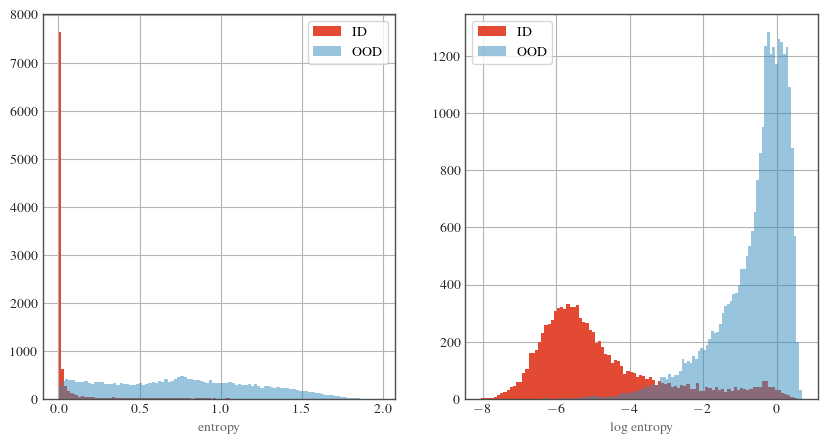

In [5]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

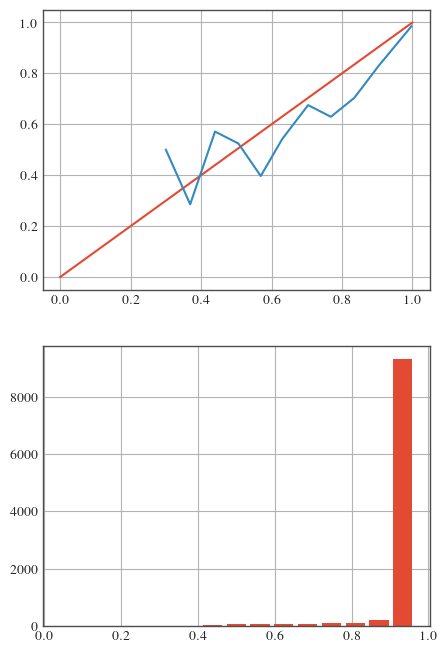

In [6]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)

In [7]:
results = []
mean_field_factors = np.linspace(0.1, 20, 25)
for mean_field_factor in mean_field_factors:
    # forward prop
    device = 'cuda'
    model.to(device)
    model.eval()
    print('Running mean field factor of', mean_field_factor)
    model.output_layer.mean_field_factor = mean_field_factor

    logits, targets = [], []
    for inp, tar in tqdm(test_loader):
        with torch.no_grad():
            logits.append(model(inp.to(device), mean_field=True).cpu())
            targets.append(tar)
    logits = torch.cat(logits)
    targets = torch.cat(targets)

    logits_ood = []
    for inp, tar in tqdm(ood_loader):
        with torch.no_grad():
            logits_ood.append(model(inp.to(device), mean_field=True).cpu())
    logits_ood = torch.cat(logits_ood)

    # Compute results
    entropy_id = ood.entropy_fn(logits.softmax(-1))
    entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
    tce_criterion = calibration.TopLabelCalibrationError()
    nll_criterion = torch.nn.CrossEntropyLoss()

    result_dict = {
        'ACC': generalization.accuracy(logits, targets)[0].item(),
        'TCE': tce_criterion(logits.softmax(-1), targets).item(),
        'NLL': nll_criterion(logits, targets).item(),
        'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
    }
    results.append(result_dict)
    print(result_dict)


Running mean field factor of 0.1


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


{'ACC': 96.29000091552734, 'TCE': 0.02013580873608589, 'NLL': 0.14613434672355652, 'AUROC': 0.953161397510756}
Running mean field factor of 0.9291666666666666


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.29000091552734, 'TCE': 0.011221996508538723, 'NLL': 0.12842990458011627, 'AUROC': 0.9648460298862938}
Running mean field factor of 1.7583333333333333


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.29000091552734, 'TCE': 0.005630067083984613, 'NLL': 0.12768174707889557, 'AUROC': 0.9698584434542104}
Running mean field factor of 2.5875


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


{'ACC': 96.29000091552734, 'TCE': 0.017667224630713463, 'NLL': 0.13565558195114136, 'AUROC': 0.9728144264751075}
Running mean field factor of 3.4166666666666665


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.29000091552734, 'TCE': 0.03422224149107933, 'NLL': 0.14933685958385468, 'AUROC': 0.9747612553779963}
Running mean field factor of 4.245833333333333


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.29000091552734, 'TCE': 0.05373658984899521, 'NLL': 0.16698792576789856, 'AUROC': 0.9761405308850645}
Running mean field factor of 5.074999999999999


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.29000091552734, 'TCE': 0.07446113973855972, 'NLL': 0.18741972744464874, 'AUROC': 0.9771678280577751}
Running mean field factor of 5.904166666666666


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.29000091552734, 'TCE': 0.0958344116806984, 'NLL': 0.2097654491662979, 'AUROC': 0.9779672076674863}
Running mean field factor of 6.7333333333333325


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.29000091552734, 'TCE': 0.11741428822278976, 'NLL': 0.23337824642658234, 'AUROC': 0.9786002900276582}
Running mean field factor of 7.562499999999999


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.29000091552734, 'TCE': 0.13886748254299164, 'NLL': 0.2577715218067169, 'AUROC': 0.9791223859096496}
Running mean field factor of 8.391666666666666


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


{'ACC': 96.29000091552734, 'TCE': 0.15995164215564728, 'NLL': 0.2825784981250763, 'AUROC': 0.9795541487400122}
Running mean field factor of 9.220833333333333


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


{'ACC': 96.29000091552734, 'TCE': 0.18049757182598114, 'NLL': 0.3075231611728668, 'AUROC': 0.9799159092655193}
Running mean field factor of 10.049999999999999


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.20039191842079163, 'NLL': 0.33239901065826416, 'AUROC': 0.9802257721266134}
Running mean field factor of 10.879166666666665


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.2195643037557602, 'NLL': 0.35705238580703735, 'AUROC': 0.9804918657805777}
Running mean field factor of 11.708333333333332


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.23797601461410522, 'NLL': 0.3813706338405609, 'AUROC': 0.9807227431622619}
Running mean field factor of 12.5375


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.2556115388870239, 'NLL': 0.4052720367908478, 'AUROC': 0.980927873386601}
Running mean field factor of 13.366666666666665


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.29000091552734, 'TCE': 0.27247196435928345, 'NLL': 0.42869916558265686, 'AUROC': 0.9811090734480638}
Running mean field factor of 14.195833333333331


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.28857049345970154, 'NLL': 0.4516126811504364, 'AUROC': 0.9812700138291333}
Running mean field factor of 15.024999999999999


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.30392807722091675, 'NLL': 0.47398775815963745, 'AUROC': 0.9814134545943455}
Running mean field factor of 15.854166666666666


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.29000091552734, 'TCE': 0.3185712695121765, 'NLL': 0.49581006169319153, 'AUROC': 0.9815391652581439}
Running mean field factor of 16.683333333333334


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.33252963423728943, 'NLL': 0.5170735716819763, 'AUROC': 0.9816529675015365}
Running mean field factor of 17.5125


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


{'ACC': 96.29000091552734, 'TCE': 0.34583476185798645, 'NLL': 0.5377786159515381, 'AUROC': 0.9817568204517517}
Running mean field factor of 18.34166666666667


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.29000091552734, 'TCE': 0.3585186004638672, 'NLL': 0.5579299926757812, 'AUROC': 0.9818518265980334}
Running mean field factor of 19.170833333333334


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.29000091552734, 'TCE': 0.37061360478401184, 'NLL': 0.5775361061096191, 'AUROC': 0.9819376920712969}
Running mean field factor of 20.0


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]

{'ACC': 96.29000091552734, 'TCE': 0.3821510374546051, 'NLL': 0.5966078042984009, 'AUROC': 0.9820158343577137}


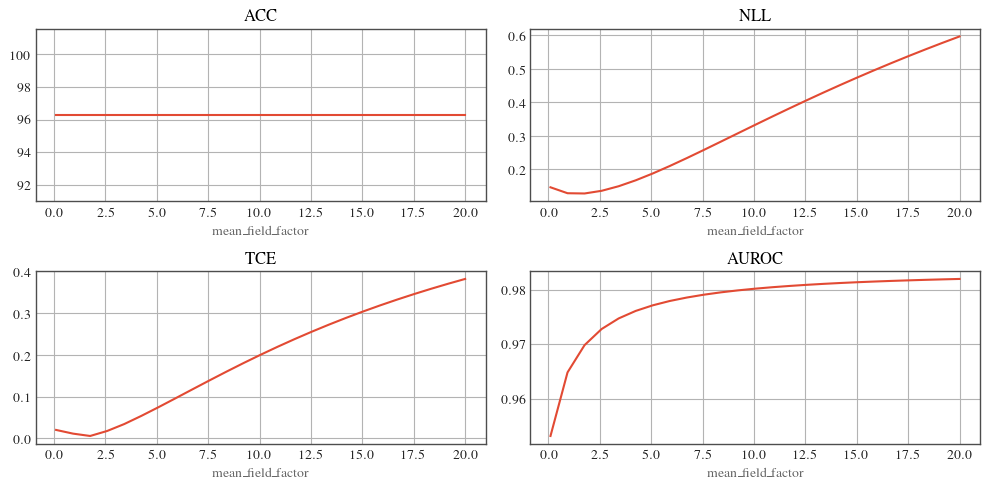

In [10]:
plt.subplot(221)
plt.title('ACC')
plt.plot(mean_field_factors, [d['ACC'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(222)
plt.title('NLL')
plt.plot(mean_field_factors, [d['NLL'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(223)
plt.title('TCE')
plt.plot(mean_field_factors, [d['TCE'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(224)
plt.title('AUROC')
plt.plot(mean_field_factors, [d['AUROC'] for d in results])
plt.xlabel('mean_field_factor')

plt.tight_layout()
plt.show()